In [2]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np
import os
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

plt.style.use(["science", "ieee"])
api = wandb.Api()
out_dir = '../output/analysis'
os.makedirs(out_dir,exist_ok=True)

# Project is specified by <entity/project-name>
runs = api.runs("kobybibas/pnml_for_dnn")


In [3]:
# prune 0.0
run = api.run("kobybibas/pnml_for_dnn/2ynrwl9c")
run.file("res_df.pkl").download(replace=True)
prune_0_df = pd.read_pickle("res_df.pkl")

# prune 0.7
run = api.run("kobybibas/pnml_for_dnn/1zbb5xj0")
run.file("res_df.pkl").download(replace=True)
prune_1_df = pd.read_pickle("res_df.pkl")

# prune 0.95
run = api.run("kobybibas/pnml_for_dnn/mvp15tzb")
run.file("res_df.pkl").download(replace=True)
prune_2_df = pd.read_pickle("res_df.pkl")

df_dict = {"0.0": prune_0_df, "0.75": prune_1_df, "0.95": prune_2_df}


In [4]:
prune_0_df.columns

Index(['test_idx', 'pnml_nf', 'pnml_regret', 'pnml_logloss', 'pnml_is_correct',
       'pnml_probs', 'genie_probs', 'erm_logloss', 'erm_is_correct',
       'erm_probs', 'test_true_label'],
      dtype='object')

In [23]:
performance_list = []
for prune_amount, df in df_dict.items():
    pnml_acc = 100 * df["pnml_is_correct"].mean()
    erm_acc = 100 * df["erm_is_correct"].mean()
    pnml_logloss = df["pnml_logloss"].mean()
    erm_logloss = df["erm_logloss"].mean()
    regret = 100 * df["pnml_regret"].mean()
    performance_list.append({'Prune amount': prune_amount, 'pNML accuracy (%)': pnml_acc,'ERM accuracy (%)': erm_acc,
    # 'pNML logloss': pnml_logloss, 
    # 'ERM logloss':erm_logloss,
    'Regret':regret})

pd.DataFrame(performance_list).round(2).set_index('Prune amount')


,pNML accuracy (%),ERM accuracy (%),Regret
Prune amount,,,
0.0,85.45,95.87,69.20
0.75,87.54,95.96,68.83
0.95,92.83,95.44,66.96


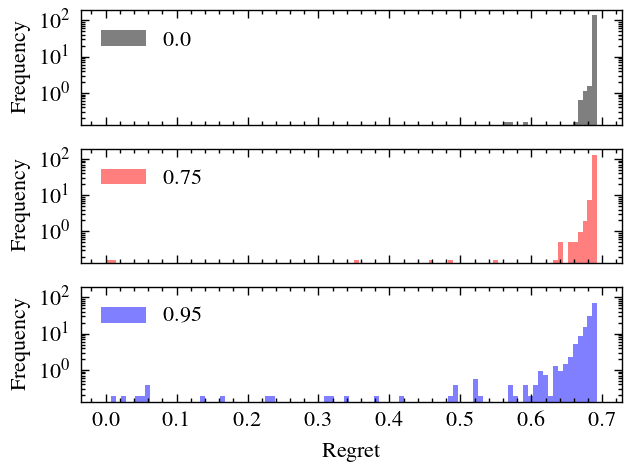

In [20]:
regret_max = max([df["pnml_regret"].max() for df in df_dict.values()])
regret_min = min([df["pnml_regret"].min() for df in df_dict.values()])

bins = np.linspace(0.0, np.log(2), 100)

fig, axs = plt.subplots(3, 1, dpi=200,sharex=True,sharey=True)

for i, (prune_amount, df) in enumerate(df_dict.items()):
    axs[i].hist(df["pnml_regret"], bins=bins, label=f'Prune amount: {prune_amount}', alpha=0.5, density=True,color=f'C{i}')
    axs[i].set_yscale('log')
    axs[i].legend()
    axs[i].set_ylabel('Frequency')
axs[-1].set_xlabel('Regret')
plt.tight_layout()
plt.show()



In [24]:
loss_max = max([df["pnml_logloss"].max() for df in df_dict.values()])
loss_min = min([df["pnml_logloss"].min() for df in df_dict.values()])

bins = np.linspace(loss_min,loss_max, 100)

fig, axs = plt.subplots(3, 1, dpi=200,sharex=True,sharey=True)

for i, (prune_amount, df) in enumerate(df_dict.items()):
    axs[i].hist(df["pnml_logloss"], bins=bins, label=f'Prune amount: {prune_amount}', alpha=0.5, density=True,color=f'C{i}')
    axs[i].set_yscale('log')
    axs[i].legend()
    axs[i].set_ylabel('Frequency')
axs[-1].set_xlabel('log-loss')
plt.tight_layout()
plt.show()
